# Imports

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# Preparation data

In [67]:
df = pd.read_csv('daily-website-visitors.csv', index_col='Date', parse_dates=True)
df

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,"2,146","1,582","1,430",152
2014-09-15,2,Monday,2,"3,621","2,528","2,297",231
2014-09-16,3,Tuesday,3,"3,698","2,630","2,352",278
2014-09-17,4,Wednesday,4,"3,667","2,614","2,327",287
2014-09-18,5,Thursday,5,"3,316","2,366","2,130",236
...,...,...,...,...,...,...,...
2020-08-15,2163,Saturday,7,"2,221","1,696","1,373",323
2020-08-16,2164,Sunday,1,"2,724","2,037","1,686",351
2020-08-17,2165,Monday,2,"3,456","2,638","2,181",457


In [68]:
df = df.replace({',':''}, regex=True)
df['First.Time.Visits'] = pd.to_numeric(df['First.Time.Visits'])
df

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,2146,1582,1430,152
2014-09-15,2,Monday,2,3621,2528,2297,231
2014-09-16,3,Tuesday,3,3698,2630,2352,278
2014-09-17,4,Wednesday,4,3667,2614,2327,287
2014-09-18,5,Thursday,5,3316,2366,2130,236
...,...,...,...,...,...,...,...
2020-08-15,2163,Saturday,7,2221,1696,1373,323
2020-08-16,2164,Sunday,1,2724,2037,1686,351
2020-08-17,2165,Monday,2,3456,2638,2181,457


<AxesSubplot:xlabel='Date'>

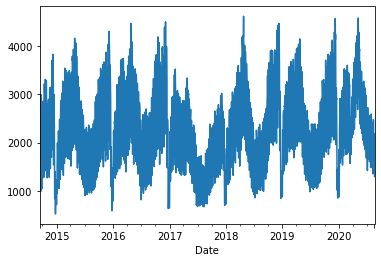

In [69]:
df['First.Time.Visits'].plot()

## Let's check how it looks like after seasonal decomposition. Probably we will find some trends.

In [70]:
seasonalDecomposition=seasonal_decompose(df['First.Time.Visits'],model='mul')

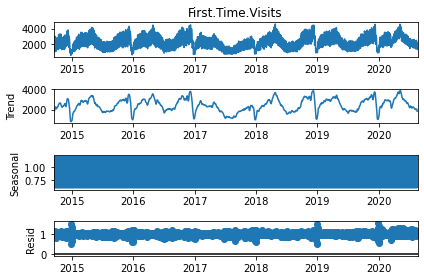

In [71]:
seasonalDecomposition.plot();

## Yes, indeed the data is seasonality, but we can see only yearly-trend and we need to know if there exists daily-trend. So let's group the data by day of week.

<AxesSubplot:xlabel='Day.Of.Week'>

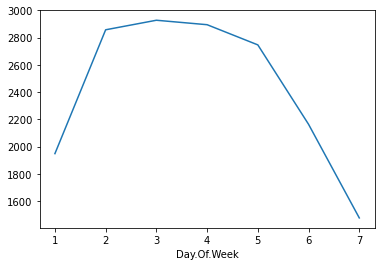

In [72]:
dfGB = df.groupby(by='Day.Of.Week').mean()['First.Time.Visits']
dfGB.plot()

## Now we can be sure that there occures daily-trend.

## Second important information about this data we need to check is the stationarity. So lest's perform the adfuller test.

In [73]:
adfuller(df['First.Time.Visits'])

(-4.478689227918476,
 0.00021482988651451264,
 26,
 2140,
 {'1%': -3.4334094211542983,
  '5%': -2.8628915360971003,
  '10%': -2.5674894918770197},
 28745.700990077945)

## We can see that the data are stationary. So now we need to choose best method to forecasting. I choose SARIMAX model and Holt-Witers' model, because they has seasonal parameter.

In [75]:
n = 30
train = df[:-n]['First.Time.Visits']
test = df[-n:]['First.Time.Visits']
start = len(train)
stop = len(df)-1

In [76]:
errors = {}

# ARIMA model

In [77]:
autoArima = auto_arima(df['First.Time.Visits'],stationary=True,seasonal=True,m=7,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=7.73 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=35276.569, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=29599.611, Time=3.68 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=31948.910, Time=3.67 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=40179.238, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=33336.106, Time=0.28 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=29626.979, Time=9.65 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=29254.027, Time=4.07 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=31681.478, Time=1.79 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=30056.982, Time=7.15 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=30878.856, Time=3.37 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=8.85 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=30

<AxesSubplot:xlabel='Date'>

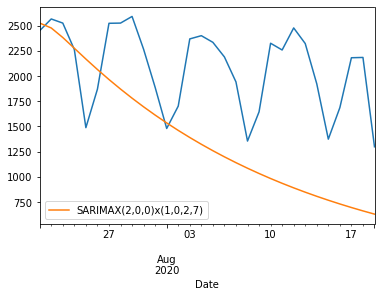

In [78]:
SarimaxModel = SARIMAX(train, order=(2,0,0), seasonal_oreder=(1,0,2,7)).fit()
predSarimax = SarimaxModel.predict(start=start,end = stop,dynamic=False).rename(f'SARIMAX(2,0,0)x(1,0,2,7)')
ax = test.plot()
predSarimax.plot(ax=ax,legend=True)

## I don't know why, but auto_arima probably doen't work correctly on my computer today, because in previous runs of auto_arima() funtion, there are some errors and warnings. We can see that the prediction isn't perfect, I have expected that it would be better. Maybe it is due to problem with this library.
## Anyway, let's perform forecasting using this method.

In [79]:
errors['Arima()'] = mean_absolute_error(test,predSarimax)

<AxesSubplot:xlabel='Date'>

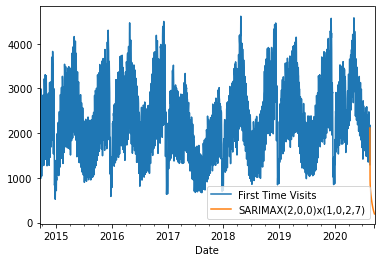

In [88]:
SarimaxForecastingModel = SARIMAX(df['First.Time.Visits'], order=(2,0,0), seasonal_oreder=(1,0,2,7)).fit()
SarimaxForecast = SarimaxForecastingModel.predict(start=stop,end = stop+30,dynamic=False).rename(f'SARIMAX(2,0,0)x(1,0,2,7)')
ax = df['First.Time.Visits'].rename('First Time Visits').plot(legend=True)
SarimaxForecast.plot(ax=ax,legend=True)

# Holt's method

## Let's check which pair of parameter get best results.

In [81]:
params = ['add', 'mul']
HoltErrors = {}
for trend in params:
    for seasonal in params:
        ExpModel = ExponentialSmoothing(train, trend=trend, seasonal=seasonal).fit()
        predHolt = ExpModel.forecast(n).rename(f'Holts-Winter ({trend}, {seasonal})')
        HoltErrors[f'Holts-Winter ({trend}, {seasonal})'] = mean_absolute_error(test,predHolt)

In [82]:
bestHolt = min(HoltErrors, key=HoltErrors.get)
bestHolt

'Holts-Winter (add, mul)'

## We can see that the smallest error occures for Holt-Winters' method with additive trend and multiplicative seasonal parameters. So now Let's train and test the model.

<AxesSubplot:xlabel='Date'>

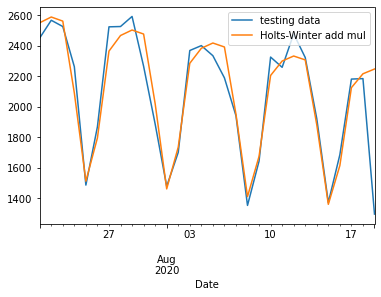

In [83]:
ExpModel = ExponentialSmoothing(train, trend='add', seasonal='mul').fit()
predHolt = ExpModel.forecast(n).rename('Holts-Winter add mul')
errors['Holts-Winter (add, mul)'] = mean_absolute_error(test,predHolt)
ax = test.rename('testing data').plot(legend=True)
predHolt.plot(ax=ax,legend=True)

## The results look much better than in SARIMAX model. Let's make forecasting.

<AxesSubplot:xlabel='Date'>

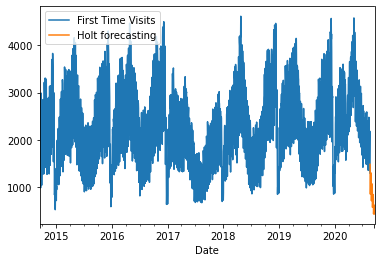

In [84]:
HoltForecastingModel = ExponentialSmoothing(df['First.Time.Visits'], trend='add', seasonal='mul').fit()
HoltForecast = HoltForecastingModel.forecast(n).rename('Holt forecasting')
ax = df['First.Time.Visits'].rename('First Time Visits').plot(legend=True)
HoltForecast.plot(ax=ax,legend=True)

In [85]:
errors

{'Arima()': 741.9650577248503, 'Holts-Winter (add, mul)': 103.2572805864535}

## We can see that Holt-Winters' results are much much better, but maybe it is because of problems with pmdarima library. Let's look at both forecasting on the same chart.

<AxesSubplot:>

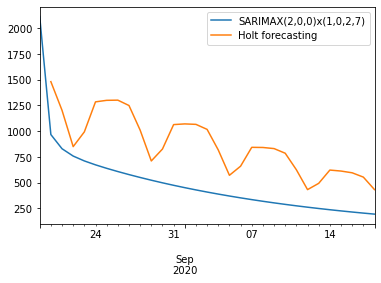

In [89]:
SarimaxForecast.plot(legend=True)
HoltForecast.plot(legend=True)